In [1]:
import os
GPU_id = 4
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())

import cudf as gd
import nvstrings
from numba import cuda

import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn,optim
import torch.nn.functional as F

from fastai.layers import embedding,bn_drop_lin
from fastai.train import Learner
from fastai.train import DataBunch
from fastai.metrics import accuracy as fastai_accuracy
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DatasetType
from fastai.callback import Callback
from fastai.torch_core import add_metrics


from datetime import datetime
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np
import time
import xgboost as xgb
import pickle
from fastai.torch_core import Module
print(gd.__version__)

0.10.0


In [3]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 32, 512)
out = transformer_encoder(src)
out.shape

torch.Size([10, 32, 512])

### Class

In [4]:
class CellDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, x_cols, y_cols):
        self.df = df
        self.x_cols = x_cols
        self.y_cols = y_cols

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        x = self.df.loc[idx,self.x_cols].values.astype(np.float32)
        y = self.df.loc[idx,self.y_cols].values.astype(np.float32)

        mask_x = (x!=x)
        x[mask_x] = 0
        mask_y = (y!=y)
        y[mask_y] = 0
        xn,xs = x[:NF],x[NF:]
        xs = xs.reshape([SF,S]).T
        return (xn,xs),y.reshape([C,S]).T

In [5]:
def mask_loss(inp, targ):
    mask = targ > 0
    mask = mask.float()
    loss = (inp-targ)**2
    loss = loss*mask
    return loss.sum()/mask.sum()

In [6]:
def my_bn_drop_lin(n_in:int, n_out:int, s:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(s)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

class SimpleTransformer(torch.nn.Module):
    
    def __init__(self,NF,SF,S,H,C,L,embs,**params):
        super(SimpleTransformer, self).__init__()
        self.NF,self.SF,self.C,self.S,self.L = NF,SF,C,S,L
        self.H = H
        total_emb = sum([i[1] for k,i in embs.items()])
        
        self.l1 = nn.Sequential(*my_bn_drop_lin(SF + total_emb,H,S,actn=nn.ReLU(inplace=True)))
        self.l2 = nn.Sequential(*my_bn_drop_lin(H + SF + total_emb,H,S, actn=nn.ReLU(inplace=True)))
        self.l3 = nn.Linear(H,self.C)
        self.e0 = embedding(embs[0][0],embs[0][1])
        self.e1 = embedding(embs[1][0],embs[1][1])
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=SF + total_emb, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.h0_fc = nn.Linear(NF-len(embs) + total_emb, self.H*L)
        self.total_emb = total_emb
        
    def forward(self, x0, x1):
        
        e0 = self.e0(x0[:,0].long())
        e1 = self.e1(x0[:,1].long())
        x0 = torch.cat([e0,e1],dim=1)
        x0 = x0.repeat(1,self.S)
        x0 = x0.view((-1,self.S,self.total_emb))
        
        #h0 = self.h0_fc(x0).view(-1,self.L,self.H).transpose(0,1)
        #m = nn.Tanh()
        #h0 = m(h0)       
       
        x1 = torch.cat([x0,x1],dim=2)
        
        yr = self.transformer_encoder(x1.transpose(0,1))
        
        y = self.l1(x1)
        yr = torch.cat([y,yr.transpose(0,1)],dim=2)
        yr = self.l2(yr)
        return self.l3(yr)
        

### Functions

In [7]:
def mean_rmse(df):
    dg = df.groupby(["cell_line", "treatment", "time", "marker"]).agg({'target':'mean'})
    dg.columns = ['rmse']
    dg['rmse'] = np.sqrt(dg['rmse'])
    return dg['rmse'].mean()

def mean_rmse_orig(df):
    df['rmse'] = (df['target'] - df['pred'])
    df['rmse'] = df['rmse']*df['rmse']
    dg = df.groupby(["cell_line", "treatment", "time", "marker"]).agg({'rmse':'mean'})
    dg.columns = ['rmse']
    dg['rmse'] = np.sqrt(dg['rmse'])
    return dg['rmse'].mean()

def inv_norm_pred(yp):
    for c,i in enumerate(valid_markers+test_markers):
        mean,std = ms[i]
        yp[:,c] = yp[:,c]*std + mean
    return yp

In [8]:
def mean_rmse_orig(df):
    df['rmse'] = (df['target'] - df['pred'])
    df['rmse'] = df['rmse']*df['rmse']
    dg = df.groupby(["cell_line", "treatment", "time", "marker"]).agg({'rmse':'mean'})
    dg.columns = ['rmse']
    dg['rmse'] = np.sqrt(dg['rmse'])
    return dg['rmse'].mean()

In [9]:
def get_valid(valid,col,cols):    
    valid['idx'] = np.arange(valid.shape[0])
    mask = valid['idx']<str_map['num']['valid']   

    for c,i in enumerate(valid_markers):
        valid.loc[mask,i] = None
    for c,i in enumerate(test_markers):
        valid.loc[~mask,i] = None
    valid.drop('idx',axis=1,inplace=True)    
    valid = valid.set_index(cols).stack().reset_index()
    valid.columns = cols+['marker',col]    
    return valid

### Load data

In [10]:
%%time
path = Path('/raid/data/ml/dream/single_cell_breast_cancer')
df = pd.read_pickle('%s/cache/rnn_data.pickle'%path)
str_map = pickle.load(open('%s/cache/miao_map.pickle'%path,'rb'))
num_tr = (df.is_va==0).sum()
num_va = (df.is_va==1).sum()
num_te = (df.is_va==2).sum()
print(num_tr,num_va,num_te,df.shape[0])
assert num_tr+num_va+num_te == df.shape[0]
for col in ['treatment','cell_line','time']:
    str_map[col] = {v:k for k,v in str_map[col].items()}

4353709 1119853 1273579 6747141
CPU times: user 1.73 s, sys: 8.88 s, total: 10.6 s
Wall time: 10.6 s


In [11]:
df.head()

,seq_len,treatment,cell_line,is_va,time_course,plate,PAM50,Neve,Marcotte,Gene.cluster,...,p.STAT3_2,p.STAT3_3,p.STAT3_4,p.STAT3_5,p.STAT5_0,p.STAT5_1,p.STAT5_2,p.STAT5_3,p.STAT5_4,p.STAT5_5
0,6,0,49,0,1,0,3,4,6,3,...,0.846357,0.733101,2.123893,2.297142,2.720982,2.069571,3.305178,3.082339,3.354231,2.780798
1,2,0,49,0,0,0,3,4,6,3,...,NaN,NaN,NaN,NaN,2.148460,2.529249,NaN,NaN,NaN,NaN
2,2,0,49,0,0,0,3,4,6,3,...,NaN,NaN,NaN,NaN,2.828693,2.568433,NaN,NaN,NaN,NaN
3,2,0,49,0,0,0,3,4,6,3,...,NaN,NaN,NaN,NaN,2.866521,2.896402,NaN,NaN,NaN,NaN
4,2,0,49,0,0,0,3,4,6,3,...,NaN,NaN,NaN,NaN,2.176365,2.768626,NaN,NaN,NaN,NaN


In [12]:
def is_seq_fea(x):
    xx = x.split('_')
    if len(xx) == 1:
        return x
    if xx[1] in '012345':
        return xx[0]
    return x
xx = []
NF = 0
for i in df.columns.values:
    x = is_seq_fea(i)
    if i==x:
        NF+=1
    if x not in xx:
        xx.append(x)
print(xx)
print(NF)

['seq_len', 'treatment', 'cell_line', 'is_va', 'time_course', 'plate', 'PAM50', 'Neve', 'Marcotte', 'Gene.cluster', 'Classification', 'AR', 'HER2', 'PGR', 'ERa', 'Age', 'primary.tumor', 'metastatic.site', 'formed.mets', 'Growth.medium', 'Origin', 'Source', 'Lehmann', 'Basal.profile', 'Responce.profile', 'Lehmann.from.Lehmann', 'ER', 'PR', 'HER2.1', 'TP53', 'Source.1', 'Tumor.type', 'Ethnicity', 'Plate.Nr', 'fCluster', 'cellID', 'seq_id', 'time', 'fileID', 'p.GSK3b', 'p.MAPKAPK2', 'p.BTK', 'p.Akt.Ser473.', 'p.ERK', 'p.HER2', 'p.PLCg2', 'p.S6', 'b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1', 'p.AKT.Thr308.', 'p.AMPK', 'p.CREB', 'p.FAK', 'p.H3', 'p.JNK', 'p.MAP2K3', 'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53', 'p.p90RSK', 'p.PDPK1', 'p.RB', 'p.S6K', 'p.SMAD23', 'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5']
37


In [13]:
def get_seq_cols(cols,N):
    return ['%s_%d'%(i,c) for i in cols for c in range(N)]

S = 6
C = 8
not_use = ['seq_len','is_va','seq_id','cellID']
NF = NF - len(not_use)

not_use_seq = ['fileID']
not_use = not_use + get_seq_cols(not_use_seq,S)

test_markers = ["p.Akt.Ser473.", "p.ERK",  "p.HER2", "p.PLCg2","p.S6"]
valid_markers = ['p.GSK3b','p.MAPKAPK2','p.BTK']
ycols = valid_markers + test_markers
ycols = get_seq_cols(ycols,S)

xcols = [i for i in df.columns if i not in not_use + ycols]
print(xcols[NF:])
SF = (len(xcols)-NF)//S

['time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5', 'b.CATENIN_0', 'b.CATENIN_1', 'b.CATENIN_2', 'b.CATENIN_3', 'b.CATENIN_4', 'b.CATENIN_5', 'cleavedCas_0', 'cleavedCas_1', 'cleavedCas_2', 'cleavedCas_3', 'cleavedCas_4', 'cleavedCas_5', 'CyclinB_0', 'CyclinB_1', 'CyclinB_2', 'CyclinB_3', 'CyclinB_4', 'CyclinB_5', 'GAPDH_0', 'GAPDH_1', 'GAPDH_2', 'GAPDH_3', 'GAPDH_4', 'GAPDH_5', 'IdU_0', 'IdU_1', 'IdU_2', 'IdU_3', 'IdU_4', 'IdU_5', 'Ki.67_0', 'Ki.67_1', 'Ki.67_2', 'Ki.67_3', 'Ki.67_4', 'Ki.67_5', 'p.4EBP1_0', 'p.4EBP1_1', 'p.4EBP1_2', 'p.4EBP1_3', 'p.4EBP1_4', 'p.4EBP1_5', 'p.AKT.Thr308._0', 'p.AKT.Thr308._1', 'p.AKT.Thr308._2', 'p.AKT.Thr308._3', 'p.AKT.Thr308._4', 'p.AKT.Thr308._5', 'p.AMPK_0', 'p.AMPK_1', 'p.AMPK_2', 'p.AMPK_3', 'p.AMPK_4', 'p.AMPK_5', 'p.CREB_0', 'p.CREB_1', 'p.CREB_2', 'p.CREB_3', 'p.CREB_4', 'p.CREB_5', 'p.FAK_0', 'p.FAK_1', 'p.FAK_2', 'p.FAK_3', 'p.FAK_4', 'p.FAK_5', 'p.H3_0', 'p.H3_1', 'p.H3_2', 'p.H3_3', 'p.H3_4', 'p.H3_5', 'p.JNK_0', 'p.JNK_1', 'p.JN

In [14]:
scols = xcols[NF:]
NF = 2
xcols = xcols[:NF] + scols
emb = {0:[7,5],1:[51,5]}
for i in xcols[:NF]:
    print(i,df[i].max(),df[i].min())

treatment 5 0
cell_line 49 0


In [15]:
print(NF,SF,S,len(xcols))

2 30 6 182


### Get databunch

In [16]:
%%time
train_ds = CellDataset(df.loc[df.is_va==0].reset_index(drop=True),xcols,ycols)
valid_ds = CellDataset(df.loc[df.is_va>0].reset_index(drop=True),xcols,ycols)

CPU times: user 4.22 s, sys: 6.88 s, total: 11.1 s
Wall time: 11.1 s


In [17]:
%%time

batch_size = 1024
cpu_workers = 16

train_dataloader = DataLoader(train_ds, batch_size=batch_size,
                        shuffle=True, num_workers=cpu_workers,
                        drop_last=True)

valid_dataloader = DataLoader(valid_ds, batch_size=batch_size,
                        shuffle=False, num_workers=cpu_workers,
                        drop_last=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 142 µs


In [18]:
%%time
databunch = DataBunch(train_dl=train_dataloader, 
                      valid_dl=valid_dataloader, 
                     )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 209 µs


### Train

In [19]:
model = SimpleTransformer(NF=NF,SF=SF,H=64,C=8,L=1,S=6,embs=emb)
#model = SimpleNN(NF=NF,SF=SF,H=32,C=8,L=1,S=6,embs=emb)

In [20]:
learn = Learner(databunch, model, loss_func=mask_loss)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.63E-03
Min loss divided by 10: 4.37E-02


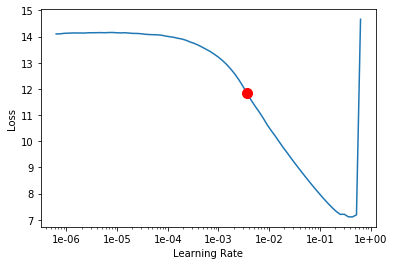

In [22]:
learn.recorder.plot(suggestion=True,skip_end=1)

In [23]:
learn.fit_one_cycle(1,max_lr=slice(0.01),callbacks=[
            SaveModelCallback(learn, every='improvement'),
            ])

epoch,train_loss,valid_loss,time
0,0.362486,0.591421,17:46


Better model found at epoch 0 with valid_loss value: 0.5914214253425598.


### Predict and validate

In [24]:
%%time
yp,yt = learn.get_preds()

CPU times: user 14 s, sys: 10.6 s, total: 24.6 s
Wall time: 6min


In [25]:
yp = yp.transpose(1,2).reshape((-1,S*C))
yp = yp.numpy()
yt = yt.transpose(1,2).reshape((-1,S*C))
yt = yt.numpy()
yp.shape

(2393432, 48)

In [26]:
masky = yt==0
ytx = yt*(1-masky)
ypx = yp*(1-masky)
(((ytx-ypx)**2).sum()/(1-masky).sum())**0.5

0.7918875000060254

In [27]:
def get_pred_df(yp=None):
    ycols = get_seq_cols(valid_markers+test_markers,6)
    scols = get_seq_cols(['time','fileID'],6)+ycols
    bcols = ['treatment','cell_line','cellID','is_va'] 
    cols = bcols + scols
    pred = valid_ds.df[cols].copy()
    if yp is not None:
        for c,i in enumerate(ycols):
            pred[i] = yp[:,c]

    iterables = [['time','fileID']+valid_markers+test_markers, [str(i) for i in range(6)]]
    newcols = pd.MultiIndex.from_product(iterables, names=['first', 'second'])
    pred = pred.set_index(bcols)
    pred.columns = newcols
    pred = pred.stack()
    pred = pred.reset_index().drop(['second'],axis=1)
    pred = pred.dropna(subset=['fileID'])
    print(pred.shape)
    return pred

In [28]:
%%time
pred = get_pred_df(yp)
truth = get_pred_df(None)
check = get_pred_df(yt)
pred.head()

(4567708, 14)
(4567708, 14)
(4567708, 14)
CPU times: user 18.8 s, sys: 17.9 s, total: 36.7 s
Wall time: 36.7 s


first,treatment,cell_line,cellID,is_va,fileID,p.Akt.Ser473.,p.BTK,p.ERK,p.GSK3b,p.HER2,p.MAPKAPK2,p.PLCg2,p.S6,time
0,5,33,4048,1,676.0,2.547996,1.959943,1.677850,1.372646,2.960517,1.582815,1.360747,3.349516,0.0
1,5,33,4048,1,683.0,2.996620,2.427516,2.555205,1.934317,3.861361,1.734233,1.652984,4.897773,2.0
2,5,33,4048,1,685.0,3.866432,2.813092,3.129608,2.727231,4.034002,2.294922,2.523062,5.366190,9.0
6,5,33,4047,1,676.0,3.696142,2.743559,2.296795,2.189386,3.748976,1.807629,2.223378,4.707635,0.0
7,5,33,4047,1,683.0,4.333675,2.597347,3.404877,2.865664,4.139786,2.393665,2.107761,4.652071,2.0


In [29]:
truth.head()

first,treatment,cell_line,cellID,is_va,fileID,p.Akt.Ser473.,p.BTK,p.ERK,p.GSK3b,p.HER2,p.MAPKAPK2,p.PLCg2,p.S6,time
0,5,33,4048,1,676.0,1.824951,0.861038,0.442259,1.10118,2.430363,1.092203,0.986227,2.81542,0.0
1,5,33,4048,1,683.0,2.394038,2.280428,0.442259,2.91985,3.424763,1.964924,1.273423,6.58871,2.0
2,5,33,4048,1,685.0,2.077608,1.743483,1.886865,1.11252,3.333516,2.801393,1.998643,5.79733,9.0
3,5,33,4047,1,676.0,0.796947,1.325784,2.255708,2.12460,4.079639,2.248888,2.056693,6.81841,0.0
4,5,33,4047,1,683.0,2.415443,2.622607,2.628697,1.84427,3.200819,2.604789,2.040694,4.20893,2.0


In [30]:
def rmse(y,yp): return ((y-yp)**2).mean()**0.5
y1 = truth.loc[truth.is_va==1,test_markers].values
yp1 = pred.loc[pred.is_va==1,test_markers].values
y2 = truth.loc[truth.is_va==2,valid_markers].values
yp2 = pred.loc[pred.is_va==2,valid_markers].values
print(rmse(y1,yp1),rmse(y2,yp2))

0.8891615639790134 0.7047144197452152


In [31]:
y1 = truth.loc[truth.is_va==1,test_markers].values
yp1 = check.loc[check.is_va==1,test_markers].values
y2 = truth.loc[truth.is_va==2,valid_markers].values
yp2 = check.loc[check.is_va==2,valid_markers].values
print(rmse(y1,yp1),rmse(y2,yp2))

0.0 0.0


In [32]:
%%time
df = pd.read_pickle('%s/cache/miao.pickle'%path).fillna(1.0)
mask = df['is_va']>0
cols = ['treatment','cell_line','time','cellID','fileID']
ycols = valid_markers+test_markers
valid = df.loc[mask,cols+ycols].copy().reset_index(drop=True)
print(valid.shape)
valid.head()

(4567708, 13)
CPU times: user 1.98 s, sys: 4.62 s, total: 6.59 s
Wall time: 6.58 s


,treatment,cell_line,time,cellID,fileID,p.GSK3b,p.MAPKAPK2,p.BTK,p.Akt.Ser473.,p.ERK,p.HER2,p.PLCg2,p.S6
0,0,0,0,1,2656,1.10118,0.499066,1.552072,0.550685,1.945108,4.030961,1.998328,4.63975
1,0,0,0,1,2689,3.10473,2.889448,3.051249,3.085023,2.688881,5.105626,2.937221,4.76504
2,0,0,0,2,2656,1.10118,1.919210,2.979495,2.044299,1.959328,4.311026,2.244438,4.39714
3,0,0,0,2,2689,3.36467,2.439262,1.977616,2.798600,3.317608,4.063840,2.644928,6.60913
4,0,0,0,3,2656,1.10118,0.499066,2.266118,2.129871,2.997009,3.031019,0.986227,5.21624


In [33]:
pred.head()

first,treatment,cell_line,cellID,is_va,fileID,p.Akt.Ser473.,p.BTK,p.ERK,p.GSK3b,p.HER2,p.MAPKAPK2,p.PLCg2,p.S6,time
0,5,33,4048,1,676.0,2.547996,1.959943,1.677850,1.372646,2.960517,1.582815,1.360747,3.349516,0.0
1,5,33,4048,1,683.0,2.996620,2.427516,2.555205,1.934317,3.861361,1.734233,1.652984,4.897773,2.0
2,5,33,4048,1,685.0,3.866432,2.813092,3.129608,2.727231,4.034002,2.294922,2.523062,5.366190,9.0
6,5,33,4047,1,676.0,3.696142,2.743559,2.296795,2.189386,3.748976,1.807629,2.223378,4.707635,0.0
7,5,33,4047,1,683.0,4.333675,2.597347,3.404877,2.865664,4.139786,2.393665,2.107761,4.652071,2.0


In [34]:
%%time
cols = ['treatment','cell_line','time','cellID','fileID']
dx = valid[cols].merge(pred,on=cols,how='left')
print(valid.shape,pred.shape,dx.shape)
dx.head()

(4567708, 13) (4567708, 14) (4567708, 14)
CPU times: user 3.12 s, sys: 1.4 s, total: 4.52 s
Wall time: 4.52 s


,treatment,cell_line,time,cellID,fileID,is_va,p.Akt.Ser473.,p.BTK,p.ERK,p.GSK3b,p.HER2,p.MAPKAPK2,p.PLCg2,p.S6
0,0,0,0,1,2656,1,1.142674,2.238217,1.958724,1.370197,4.788645,1.002721,1.335214,3.330403
1,0,0,0,1,2689,1,3.940696,4.248232,3.057132,4.725414,5.394075,2.502265,4.359433,5.752574
2,0,0,0,2,2656,1,2.739455,3.002316,3.312043,2.364962,4.580275,1.703324,1.656855,4.211334
3,0,0,0,2,2689,1,3.935743,2.899704,3.484223,3.820375,4.057366,2.158848,2.852460,5.443326
4,0,0,0,3,2656,1,3.118565,2.810873,1.946611,3.297936,3.996579,1.821018,2.213363,6.190029


In [35]:
cols = ['treatment','cell_line','time','cellID','fileID']
dx = dx[cols+valid_markers+test_markers]

In [36]:
%%time
valid = get_valid(valid,'target',cols)
dx = get_valid(dx,'pred',cols)
valid['pred'] = dx['pred'].values

for col in ['treatment','cell_line','time']:
    valid[col] = valid[col].map(str_map[col])
print(valid.shape)
valid.head()

(18072424, 8)
CPU times: user 5.84 s, sys: 5 s, total: 10.8 s
Wall time: 10.8 s


,treatment,cell_line,time,cellID,fileID,marker,target,pred
0,EGF,184A1,0.0,1,2656,p.Akt.Ser473.,0.550685,1.142674
1,EGF,184A1,0.0,1,2656,p.ERK,1.945108,1.958724
2,EGF,184A1,0.0,1,2656,p.HER2,4.030961,4.788645
3,EGF,184A1,0.0,1,2656,p.PLCg2,1.998328,1.335214
4,EGF,184A1,0.0,1,2656,p.S6,4.639750,3.330403


In [37]:
print(valid.shape,pred.shape,dx.shape)

(18072424, 8) (4567708, 14) (18072424, 7)


In [38]:
score = mean_rmse_orig(valid)
score

0.7664350271224976

### Write submission

In [39]:
%%time
ycols = valid_markers+test_markers

cols = ['treatment','cell_line','time','cellID','fileID']
mask = df['is_va']>0
test = df.loc[mask,cols+ycols]

dx = test[cols].merge(pred,on=cols,how='left')

for c,i in enumerate(ycols):
    test[i] = dx[i].values
test['idx'] = np.arange(test.shape[0])
mask = test['idx'] >= str_map['num']['valid']   
test = test.loc[mask]
cols = cols+test_markers
test = test[cols]
test.head()

CPU times: user 3.93 s, sys: 2.26 s, total: 6.19 s
Wall time: 6.19 s


,treatment,cell_line,time,cellID,fileID,p.Akt.Ser473.,p.ERK,p.HER2,p.PLCg2,p.S6
11022341,0,29,0,1,1600,3.534444,3.522197,4.276707,2.312029,4.455772
11022342,0,29,0,1,1662,3.372510,2.995671,3.812343,1.985252,5.190228
11022343,0,29,0,2,1600,3.151032,2.613801,3.521856,1.851977,5.121676
11022344,0,29,0,2,1662,4.099051,4.158844,5.206102,3.863457,6.929930
11022345,0,29,0,3,1600,3.721421,2.936486,3.046387,1.734472,5.022242


In [40]:
for col in ['treatment','cell_line','time']:
    test[col] = test[col].map(str_map[col])
test.head()

,treatment,cell_line,time,cellID,fileID,p.Akt.Ser473.,p.ERK,p.HER2,p.PLCg2,p.S6
11022341,EGF,LY2,0.0,1,1600,3.534444,3.522197,4.276707,2.312029,4.455772
11022342,EGF,LY2,0.0,1,1662,3.372510,2.995671,3.812343,1.985252,5.190228
11022343,EGF,LY2,0.0,2,1600,3.151032,2.613801,3.521856,1.851977,5.121676
11022344,EGF,LY2,0.0,2,1662,4.099051,4.158844,5.206102,3.863457,6.929930
11022345,EGF,LY2,0.0,3,1600,3.721421,2.936486,3.046387,1.734472,5.022242


In [41]:
%%time
sample_sub = pd.read_csv(path/'prediction_template/subchallenge_1_template_data.csv')
sample_sub.head()

CPU times: user 1.23 s, sys: 232 ms, total: 1.46 s
Wall time: 1.46 s


,glob_cellID,cell_line,treatment,time,cellID,fileID,p.ERK,p.Akt.Ser473.,p.S6,p.HER2,p.PLCg2
0,1,AU565,EGF,0.0,1,59,NaN,NaN,NaN,NaN,NaN
1,2,AU565,EGF,0.0,1,122,NaN,NaN,NaN,NaN,NaN
2,3,AU565,EGF,0.0,2,59,NaN,NaN,NaN,NaN,NaN
3,4,AU565,EGF,0.0,2,122,NaN,NaN,NaN,NaN,NaN
4,5,AU565,EGF,0.0,3,59,NaN,NaN,NaN,NaN,NaN


In [42]:
%%time
print(sample_sub.shape)
markers = ['p.ERK','p.Akt.Ser473.','p.S6','p.HER2','p.PLCg2']
cols = ['cell_line','treatment','time','cellID','fileID']
sub = sample_sub.drop(markers,axis=1)
sub = sub.merge(test,on=cols,how='left')
sub = sub[['glob_cellID']+cols+markers]
print(sub.shape)
sub.head()

(2383058, 11)
(2383058, 11)
CPU times: user 1.7 s, sys: 424 ms, total: 2.13 s
Wall time: 2.12 s


,glob_cellID,cell_line,treatment,time,cellID,fileID,p.ERK,p.Akt.Ser473.,p.S6,p.HER2,p.PLCg2
0,1,AU565,EGF,0.0,1,59,4.205410,4.175171,5.774653,4.379822,2.613434
1,2,AU565,EGF,0.0,1,122,4.236371,4.396259,7.038603,4.866480,2.903614
2,3,AU565,EGF,0.0,2,59,4.230805,4.674214,6.315081,4.492562,2.501034
3,4,AU565,EGF,0.0,2,122,3.411083,4.405706,7.091732,4.453313,2.352571
4,5,AU565,EGF,0.0,3,59,2.486024,3.422048,4.562881,3.414118,1.787604


In [43]:
for i in markers:
    print(i,sub[i].isnull().sum())

p.ERK 0
p.Akt.Ser473. 0
p.S6 0
p.HER2 0
p.PLCg2 0


In [44]:
%%time
clock = "{}".format(datetime.now()).replace(' ','-').replace(':','-').split('.')[0]
output_name = path/('output/sub1_transformer_%s_rmse_%.4f.csv'%(clock,score))
print(output_name)
sub.to_csv(output_name,index=False)

/raid/data/ml/dream/single_cell_breast_cancer/output/sub1_transformer_2019-10-30-16-40-25_rmse_0.7664.csv
CPU times: user 18.5 s, sys: 324 ms, total: 18.8 s
Wall time: 18.8 s


In [45]:
backup = '%s/backup/sub1_%s_rmse_%.4f'%(str(path),clock,score)
os.mkdir(backup)
cmd = 'cp *.py *.ipynb %s'%(backup)
os.system(cmd)

0